# Assignment 4

Approximate time needed: 6-7 hours
    
**DLT and Epipolar Lines**

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

1. For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

2. The second part of this assignment will require you to construct epipolar lines on two corresponding images.

3. The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

In [1]:
# Import everything
import numpy as np
import cv2 as cv
print(f"Using OpenCV Version: {cv.__version__}")
from matplotlib import pyplot as plt

Using OpenCV Version: 4.5.3


---


## 4.1 DLT

The Direct Linear Transform method for camera calibration (using correspondences)

**References**

- Cyrill Stachniss YouTube videos
    - Camera Parameters: [long](https://www.youtube.com/watch?v=uHApDqH-8UE&t=1181s), [short](https://www.youtube.com/watch?v=ND2fa08vxkY)
    - Direct Linear Transform: [long](https://www.youtube.com/watch?v=3NcQbZu6xt8), [short](https://www.youtube.com/watch?v=Fdwa0UEJ_F8)
    - Zhang's Method: [long](https://www.youtube.com/watch?v=-9He7Nu3u8s), [short](https://www.youtube.com/watch?v=26nV4oDLiqc)

### Part 1: Generate Correspondences

The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [2]:
dlt_file_name = "./q1/dlt1.jpeg"

The given code was using matplotlib and was taking long durations to execute. It has been stored in a separate file and a version using [OpenCV](https://docs.opencv.org/4.x/) has been used here. The following are for reference

1. Basic image handling in OpenCV: tutorial [here](https://docs.opencv.org/4.x/db/deb/tutorial_display_image.html)
    1. [cv.imread](https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56): Reads an image and stores as numpy.ndarray, shape is (height, width, channels). Note that the channels in OpenCV are in BGR by default.
    2. [cv.imshow](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga453d42fe4cb60e5723281a89973ee563): View images
2. Mouse event handling in OpenCV: tutorial [here](https://docs.opencv.org/4.x/db/d5b/tutorial_py_mouse_handling.html)
    1. Window management: [cv.namedWindow](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga5afdf8410934fd099df85c75b2e0888b), [cv.resizeWindow](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga9e80e080f7ef33f897e415358aee7f7e), [cv.destroyWindow](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga851ccdd6961022d1d5b4c4f255dbab34)
    2. Assign callback function using [cv.setMouseCallback](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga89e7806b0a616f6f1d502bd8c183ad3e). The function takes five arguments: [event](https://docs.opencv.org/4.x/d0/d90/group__highgui__window__flags.html#ga927593befdddc7e7013602bca9b079b0), x, y (coordinates of operation), [flags](https://docs.opencv.org/4.x/d0/d90/group__highgui__window__flags.html#gaab4dc057947f70058c80626c9f1c25ce) and some additional parameters (can be passed). 
3. Drawing functions: tutorial [here](https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html)
    1. Draw a circle using [cv.circle](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670)
    2. Write text at a point using [cv.putText](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga5126f47f883d730f633d74f07456c576)

In [3]:
img = cv.imread(dlt_file_name)
_img = img.copy()   # Don't alter img
img_points = []
_img_col = []

def img_win_event(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONUP:
        print(f"Clicked on point (x, y): {x}, {y}")
        img_points.append([x, y])
        # Random color to the point (bright colors)
        _img_col.append(tuple(  # OpenCV needs tuple colors
            map(int, np.random.randint(100, 255, 3))))

img_winname = "Image"
cv.namedWindow(img_winname, cv.WINDOW_NORMAL)   # Resizable window
cv.resizeWindow(img_winname, 500, 900)  # Set initial size
cv.setMouseCallback(img_winname, img_win_event) # Attach mouse event

while True:
    cv.imshow(img_winname, _img)
    # Show the markers that are currently selected
    for i, ((cx, cy), col) in enumerate(zip(img_points, _img_col)):
        cv.circle(_img, (cx, cy), 15, col, -1)
        cv.putText(_img, f"{i+1}", (cx, cy-15), 
            cv.FONT_HERSHEY_SIMPLEX, 1.5, col, 2, cv.LINE_AA)
    k = cv.waitKey(1)
    if k == ord('q'):
        break

cv.destroyWindow(img_winname)
img_points = np.array(img_points)

Clicked on point (x, y): 349, 504
Clicked on point (x, y): 127, 581
Clicked on point (x, y): 516, 567
Clicked on point (x, y): 338, 735
Clicked on point (x, y): 320, 216
Clicked on point (x, y): 81, 341
Clicked on point (x, y): 570, 335


In [4]:
# In case the above code fails, close the window (prevent freezing)
cv.destroyAllWindows()

In [5]:
print(f"Image points are (x, y): \n{img_points}")
# Save it to a file
# np.save("./results/q1/image-points.npy", img_points)
# Retrieve from backup
# _img_points = np.load("./results/q1/image-points.npy")

Image points are (x, y): 
[[349 504]
 [127 581]
 [516 567]
 [338 735]
 [320 216]
 [ 81 341]
 [570 335]]


The image points are picked as follows

![Points on cube](./results/q1/cube-points.png)

The image coordinates are as follows (X, Y values)

```txt
array([[346, 501],
       [127, 582],
       [516, 567],
       [338, 735],
       [320, 215],
       [ 84, 340],
       [569, 334]])
```

7 points were chosen to experiment with an extra validation point


After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

Choosing the origin the point diagonally opposite to point `1` (hidden, innermost corner of the cube). The X axis is along the left edge of that point, Y axis is along the right edge of that point and the Z axis is upwards (towards point `5`). Using this, the point coordinates are derived. A side length is considered to be `4 units`.


In [6]:
world_points = np.array([   # Each index is [X, Y, Z]
    [4, 4, 4],  # Point 1
    [4, 0, 0],  # Point 2
    [0, 4, 0],  # Point 3
    [4, 4, 0],  # Point 4
    [0, 0, 4],  # Point 5
    [4, 0, 4],  # Point 6
    [0, 4, 4],  # Point 7
])

### Part 2: Calculate the Projection Matrix

Calculate the projection matrix $\mathbf{P}$ that relates the points in world frame to the points in the image coordinates.

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [7]:
# Calculate and return the camera projection matrix P
def calc_P(wpts: np.ndarray, ipts: np.ndarray):
    """
        Calculates the camera projection matrix P, such that x = P * X
        where X is 4, 1 (homogenized world point) and x is 3, 1
        (homogenized image point). P is 3, 4: the camera projection
        matrix. Uses DLT method: At least 6 point correspondences (not
        lying in a plane) are needed.

        Parameters:
        - wpts: np.ndarray  shape: N, 3
            The points in the world coordinate (non-homogenized)
        - ipts: np.ndarray  shape: N, 2
            Non-homogenized point correspondences of the world points
            in the image
        
        Returns:
        - P: np.ndarray     shape: 3, 4
            The camera projection matrix. The norm of the flattened
            matrix (vector) is 1.
    """
    # Number of correspondences
    N = wpts.shape[0]
    # Homogenized correspondences
    X = np.hstack((wpts, np.ones((N, 1))))
    x = np.hstack((ipts, np.ones((N, 1))))
    # Homogenized equations for i: a_i * p = 0
    a_i = lambda i: np.vstack((
        np.hstack((-X[i], np.zeros(4), x[i][0]*X[i])),
        np.hstack((np.zeros(4), -X[i], x[i][1]*X[i]))
    ))
    # Stacked homogenized matrix: A * p = 0
    A = np.vstack([a_i(i) for i in range(N)])
    # -- p = Null space of A --
    # SVD of A
    U, D, Vh = np.linalg.svd(A)
    p = Vh.T[:, -1] # Last column of V
    # Reshape vector to matrix
    P = p.reshape(3, 4)
    return P


Estimate the Camera Projection matrix: $\mathbf{P}$

In [8]:
P = calc_P(world_points[0:6], img_points[0:6])
print(f"Camera projection matrix (3, 4) = \n{P}")

Camera projection matrix (3, 4) = 
[[-9.22320021e-02  6.84418966e-02 -2.46007898e-02  5.67597532e-01]
 [ 2.59835358e-02  2.98338663e-02 -1.21924016e-01  8.04737787e-01]
 [-5.77856610e-05 -4.11334576e-05 -8.18708390e-05  1.79456114e-03]]


In [9]:
# Test the camera projection (verification)
test_points = [1, 3, 7]    # Test points
dev_pix_thres = 10   # Threshold in pixel deviation (10 pixels)
for tp in test_points:
    t = tp - 1
    # Test point (world homogenized coordinates)
    test_X = np.hstack((world_points[t], 1)).T    # Point as 4, 1
    exp_x = np.hstack((img_points[t], 1)).T     # Point as 3, 1
    # Get x through P (P is )
    tx = P @ test_X
    if np.isclose(tx[2], 0):
        print("Point in P2 is at infinity (last value 0)")
    else:
        tx = tx / tx[2] # Normalize it (last element should be 1)
        dev = np.linalg.norm(exp_x - tx)
        if dev < dev_pix_thres:
            print(f"Test {tp}: Deviation of {dev:.3f} pixels")
        else:
            print(f"Test {tp}: Deviation = {dev:.3f}, too high!")

Test 1: Deviation of 0.322 pixels
Test 3: Deviation of 0.191 pixels
Test 7: Deviation of 0.393 pixels


As observed, there is very little deviation even in the 7th correspondence, though it wasn't used to find P. It can be included and the deviation will be even lesser (but let's keep it separate).

### Theory

- Explain how DLT is implemented and show why it works (proof)
- When does DLT fail?

#### DLT Explanation

The **Direct Linear Transform** is a method to extract a homogeneous relation between corresponding points. In the context of camera calibration, where the aim is to estimate the camera extrinsic and intrinsic parameters, it is the process of finding the camera projection matrix, given the point correspondences (pairs of relations, relating the 3D point coordinates in the world with the 2D image coordinates). Here, the projection equation is rearranged into an equation where finding the null space gives the resultant vector directly.


**Implementation**

The above implementation is described here as steps

1. **Correspondences**: The 3D world to 2D image point correspondences are obtained. Manual identification is used here, but this can be done by the help of a depth sensor, and detection algorithms with a camera (in a real setting). Basically, we have the correspondences $\mathbf{X}_i \leftrightarrow \mathbf{x}_i = [ X_i, Y_i, Z_i, 1 ] \leftrightarrow [ x_i, y_i, 1 ]$ (note that the correspondences are homogenized) relating the 3D point in world to point in pixel coordinates. These points are related as $\mathbf{x}_{i_{(3,1)}} = \mathbf{P}_{(3, 4)} \mathbf{X}_{i_{(4, 1)}}$ where the points are homogenized.
2. **Equation Modeling**: The homogeneous equation is created by rearranging the terms (from correspondences).

    $$
    \mathbf{A}_{(2m, 12)} \mathbf{p}_{(12, 1)} = 0 \quad \textup{where}\; \mathbf{p} = \begin{bmatrix}
        \mathbf{P}_{1,:}^\top \\ \mathbf{P}_{2,:}^\top \\ \mathbf{P}_{3,:}^\top
        \end{bmatrix} \; \textup{and} \; \mathbf{A} = \begin{bmatrix}
        \mathbf{a}_{x_1}^\top \\
        \mathbf{a}_{y_1}^\top \\
        \vdots \\
        \mathbf{a}_{x_i}^\top \\
        \mathbf{a}_{y_i}^\top \\
        \vdots \\
        \mathbf{a}_{x_m}^\top \\
        \mathbf{a}_{y_m}^\top \\
        \end{bmatrix} ; \; \begin{bmatrix}
        \mathbf{a}_{x_i}^\top \\
        \mathbf{a}_{y_i}^\top
        \end{bmatrix} = \begin{bmatrix}
        -\mathbf{X}_i^\top & \mathbf{0}^\top & x_i \mathbf{X}_i^\top \\
        \mathbf{0}^\top & -\mathbf{X}_i^\top & y_i \mathbf{X}_i^\top
        \end{bmatrix}
    $$

    The above formulation is true for $m$ correspondences, here $m=6$ is used (6 correspondences). It can be noted that vector $\mathbf{p}$ is created by using the rows of $\mathbf{P}$ and vertically stacking them as columns.

3. **Null Space**: The relation $\mathbf{Ap} = 0$ may not exactly hold true, mostly because of noisy correspondences, measurements, inexactness, numerical instability, etc. It is therefore best to minimize $\left \| \mathbf{Ap} \right \|$ under the constraint $\left \| \mathbf{p} \right \| = 1$. We perform the _Singular Value Decomposition_ of $\mathbf{A}$ and get the last column of matrix $\mathbf{V}$ (right eigenvectors) as $\mathbf{p}$. This result is the closest to the null space of $\mathbf{A}$.

Once we have $\mathbf{p}$, we can convert it back to $\mathbf{P}$ (break into parts of 4 and arrange the parts as rows). We have achieved the camera projection matrix.

**Proof** (why it works) through **Derivation**

From above, we get the ideal condition that

$$ \mathbf{A}_{(2m, 12)} \mathbf{p}_{(12, 1)} = 0 \rightarrow \mathbf{A} \mathbf{p} = 0 $$

Basically, $\mathbf{p}$ is _ideally_ the **null space** of matrix $\mathbf{A}$

However, in reality, $\mathbf{A} \mathbf{p} \approx 0$. This may be because of noisy correspondences, measurements, inexactness, numerical instability, etc. In this case, the objective becomes to get the determinant minimized. This means, we get the $\mathbf{p}$ vector as

$$ \mathbf{p} = \underset{\mathbf{p'}}{\textup{argmin}}  \left \| \mathbf{A\,p'} \right \| $$

Where $\left \| \mathbf{B} \right \|$ is the matrix determinant of $\mathbf{B}$. However, note that these are homogeneous equations. In order to avoid the trivial zero condition, and to get a unique solution (since the solutions are parameterized by 1 DoF), we set the constraint $\left \| \mathbf{p} \right \| = 1$ (where $\left \| \mathbf{b} \right \|$ is the norm of the vector $\mathbf{b}$). Now, the problem becomes

$$ \textup{min} \left \| \mathbf{A\,p} \right \| \quad \textup{such that} \, \left \| \mathbf{p} \right \| = 1 $$

Through SVD (Singular Value Decomposition), we can write $\mathbf{A} = \mathbf{UDV^\top}$. Note that $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices (determinant is 1 and inverse is the same as transpose). We get

$$ \textup{min} \left \| \mathbf{UDV^\top \,p} \right \| \quad \textup{such that} \, \left \| \mathbf{p} \right \| = 1 $$

We can get a separate vector for the last term, that is $\mathbf{y} = \mathbf{V^\top p}$. Note that since $\mathbf{V}$ is orthogonal (so is its transpose), $\left \| \mathbf{y} \right \| = \left \| \mathbf{V^\top \, p} \right \| = \left \| \mathbf{p} \right \| = 1$ (we can modify the constraint). The problem is now formatted as

$$ \textup{min} \left \| \mathbf{UD \, y} \right \| \quad \textup{such that} \, \left \| \mathbf{y} \right \| = 1 $$

Since $\mathbf{U}$ is orthogonal (determinant is 1) and determinant is distributive over product, $\left \| \mathbf{UD \, y} \right \| = \left \| \mathbf{D \, y} \right \|$. This gives

$$ \textup{min} \left \| \mathbf{D \, y} \right \| \quad \textup{such that} \, \left \| \mathbf{y} \right \| = 1 $$

Note that $\mathbf{D}$ is a diagonal matrix, with the entries in descending order (a property of SVD implementation). The **best** method of getting the smallest value out of it will be when only that smallest diagonal entry is returned by $\left \| \mathbf{D \, y} \right \|$. This smallest diagonal entry is also the last element of the diagonal. To pick that element, we have to use $\mathbf{y} = \left [ 0, 0, \cdots, 0, 1 \right ]$.

We can note that $\mathbf{y} = \mathbf{V^\top \, p} \Rightarrow \mathbf{p} = \mathbf{V \, y}$ and when $\mathbf{y} = \left [ 0, 0, \cdots, 0, 1 \right ]$, we are essentially picking the **last column** of $\mathbf{V}$ matrix. Hence, $\mathbf{p}$ is the last column of $\mathbf{V}$.

Note that $\mathbf{p}$ was obtained by using the rows of $\mathbf{P}$ matrix (the main projection matrix) and vertically stacking them as a long (12, 1) column vector. We can now again break $\mathbf{p}$ vector into three parts (four elements each), arrange these parts as rows of a matrix and stack them into forming the (3, 4) **projection matrix** $\mathbf{P}$.

As seen through the above proof, choosing the last column of the matrix $\mathbf{D}$ (diagonal matrix of singular values in descending order) minimizes $\left \| \mathbf{D \, y} \right \|$, where $\mathbf{y} = \mathbf{V^\top \, p}$. Therefore, $\mathbf{p}$ obtained (through the last column of $\mathbf{V}$) is the most **optimal** solution.

#### DLT Shortcomings

In order to use DLT, we need to satisfy the following constraints

1. Each point brings with it two constraints (one in $x$ and another in $y$ of image coordinate). Since the camera projection matrix has 11 degrees of freedom / unknown parameters (5 intrinsic and 6 extrinsic), **we will require at least 6 correspondences** to find the correct $\mathbf{P}$ matrix.
2. It is important that $\mathbf{A}$ does not loose rank. This will happen when all the points lie on a plane (that is, all the correspondences actually lie one a flat plane in the real world). In this case, since it will be possible to represent different rows (consecutive pairs of them) in linear combinations of others, the matrix $\mathbf{A}$ will loose rank. In this case, finding the matrix $\mathbf{P}$ becomes impossible (as at least one singular value will become 0).

Hence, DLT will fail if we have fewer than 6 correspondences or if the points in the world lie in a plane.

### Part 3: Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix. Note that the last point is not used here because it wasn't used to find $\mathbf{P}$ (it's only for cross-validation).

In [10]:
#Get reprojected points
def get_points(P: np.ndarray, X_world: np.ndarray):
    X = np.hstack((X_world, np.ones((X_world.shape[0], 1)))).T
    _x = P @ X  # Homogeneous image points as 3, N
    return _x / _x[2]   # Normalize the h-points (last value 1)

#Get reprojection error
def get_err(x_img, X_world, P):
    # Actual value (correspondences)
    x = np.hstack((x_img, np.ones((x_img.shape[0], 1)))).T
    # From P (re-projection)
    _x = get_points(P, X_world)
    # Get reprojection error
    d_vect = _x - x
    r_err = np.sum(np.linalg.norm(d_vect, axis=0)**2)
    return r_err

In [11]:
x, X = img_points[0:6], world_points[0:6]   # All points used
r_err = get_err(x, X, P)
print(f"Reprojection Error is {r_err:.5f}")

Reprojection Error is 0.49047


### Part 4: Getting intrinsic and extrinsic parameters

Now that $\mathbf{P}$ is known, get the intrinsic parameters (matrix $\mathbf{K}$) and the extrinsic parameters (matrix $\left [ \mathbf{R} | \mathbf{t} \right ]$).


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

**Method**

We can write the camera projection matrix as

$$ \mathbf{P} = \mathbf{K R} \left [ \mathbf{I} \mid -\mathbf{X}_O \right ] = \left [ \mathbf{K R} \mid -\mathbf{K R} \, \mathbf{X}_O \right ] $$

Assuming $\mathbf{H} = \mathbf{K R}$ and $\mathbf{h} = - \mathbf{K R} \, \mathbf{X}_O = -\mathbf{H} \, \mathbf{X}_O$, we can readjust the above equations as

$$ \mathbf{P} = \left [ \mathbf{H \mid h} \right ] $$

From this, it is clear that $\mathbf{X}_O = -\mathbf{H}^{-1} \mathbf{h}$. Now, we only need to find $\mathbf{R}$ (rotation matrix) and $\mathbf{K}$ (the camera calibration matrix). Let's see the inverse of $\mathbf{H}$

$$ \mathbf{H}^{-1} = \left( \mathbf{KR} \right )^{-1} = \mathbf{R}^{-1} \, \mathbf{K}^{-1} = \mathbf{R}^\top \, \mathbf{K}^{-1} $$

Performing the [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition) of $\mathbf{H}^{-1}$ (this can be done using [numpy.linalg.qr](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html) in numpy), we can decompose it into $\mathbf{H}^{-1} = QR$ (here, $Q$ is an orthogonal matrix and $R$ is an upper / right triangular matrix). We now finally have $Q \equiv \mathbf{R}^\top$ and $R \equiv \mathbf{K}^{-1}$. This gives us

$$ \mathbf{R} = Q^\top \quad \textup{and} \quad \mathbf{K} = R^{-1} $$

Note that because of the camera image coordinates, the screen placement has been emulated to be in the front of the camera. This will require adjustment (as it has to be behind the principle / pole of the camera). A simple 180 degree rotation to $\mathbf{R}$ about the Z axis of the world (vertically up) should work (this is transform w.r.t. a fixed frame, so pre-multiply it). The same adjustment will then also be needed for $\mathbf{K}$, but, to maintain the $\mathbf{H} = \mathbf{KR}$ relation, the adjustment to K will be a pose-multiplication. Also, K has to be homogenized (the last element has to be scaled to 1). This means, the last step for rectification is as follows

$$ \mathbf{R} \leftarrow \textup{Rot}(\mathbf{Z}, \pi) \times \mathbf{R} \quad \textup{and} \quad \mathbf{K} \leftarrow \frac{\mathbf{K} \times \textup{Rot}(\mathbf{Z}, \pi)}{K_{3,3}} $$

Where $\textup{Rot}(\mathbf{Z}, \pi) = \textup{diag}(-1, -1, 1)$ and $K_{3,3}$ is the last row's last column element of $\mathbf{K}$. With this rectification, the intrinsic and extrinsic parameters have been obtained. Note that there must be a negative focal length in Y direction (image is vertically inverted in the pinhole model).


In [12]:
def ret_RKT(P):
    # Decompose into H matrix and h vector
    H = P[0:3, 0:3]
    h = P[0:3, 3]
    # Retrieve X_O
    X_O = -np.linalg.inv(H) @ h
    # Invert H
    H_inv = np.linalg.inv(H)
    # QR Decomposition to H_inv
    q, r = np.linalg.qr(H_inv)
    rot_z_pi = np.diag([-1, -1, 1])
    # R calculation
    R = q.T
    R = rot_z_pi @ R
    # K calculation
    K = np.linalg.inv(r)
    K = K @ rot_z_pi / K[2,2]
    return R, K, X_O

R, K, T = ret_RKT(P)

In [13]:
# Reconstruct the P matrix using K, R, T (= X_O)
P_re = K @ R @ np.hstack((np.eye(3), -T.reshape(3, 1)))
# Calculate reprojection error
rp_err = get_err(img_points[0:6], world_points[0:6], P_re)
# This should be the same as before
print(f"Reprojection error (from reconstructed P) is {rp_err:.5f}")

Reprojection error (from reconstructed P) is 0.49047


#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

In [14]:
if np.allclose(R @ R.T, np.eye(3)):
    print("Rotation Matrix is orthogonal")
if np.allclose(P / P[2, 3], P_re / P_re[2, 3]):
    print("The intrinsic and extrinsic parameters seem to produce the"
        " same matrix (homogenized) by setting the last element to 1")

Rotation Matrix is orthogonal
The intrinsic and extrinsic parameters seem to produce the same matrix (homogenized) by setting the last element to 1


**Reproject the world points with P matrix you have obtained via DLT and visualize**

In [15]:
# Get the world points in homogeneous coordinates
X_world = world_points
X = np.hstack((X_world, np.ones((X_world.shape[0], 1)))).T
_x = P_re @ X
x = _x / _x[2]
reimg_points = x[0:2, :].T

Marker: + for actual and x for re-projection


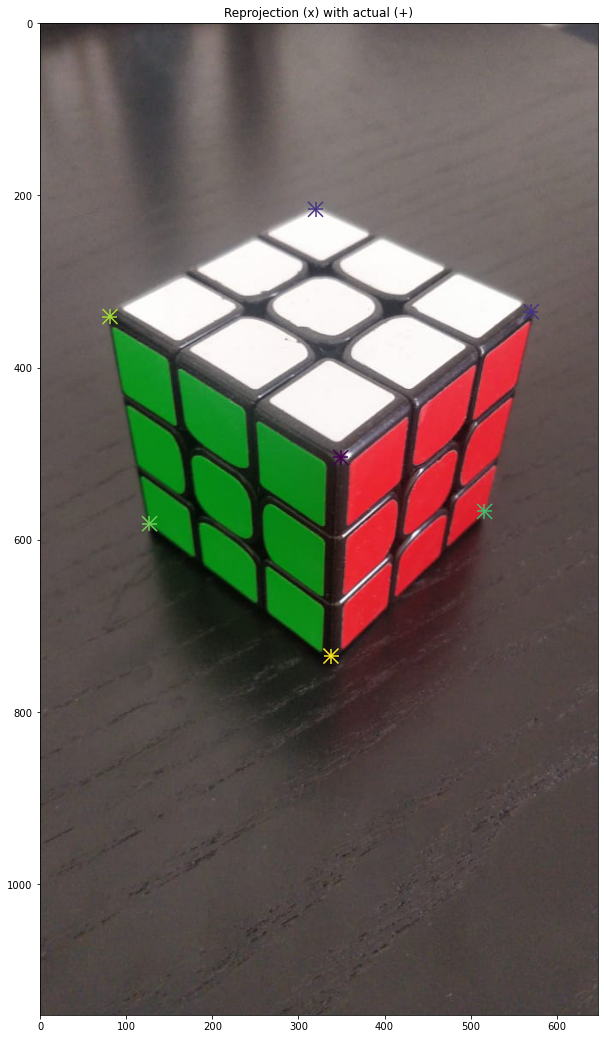

In [16]:
# OpenCV to Matplotlib (BGR to RGB)
img_plt = img.copy()
img_plt = cv.cvtColor(img_plt, cv.COLOR_BGR2RGB)
# Show image
plt.figure(figsize=(10, 20))
N = reimg_points.shape[0]   # Number of points
colors = np.random.rand(N)
area = (15 * np.ones(N))**2
print("Marker: + for actual and x for re-projection")
plt.title("Reprojection (x) with actual (+)")
# Color of markers
plt.imshow(img_plt)
# Image points
plt.scatter(img_points[:, 0], img_points[:, 1], c=colors, s=area, 
    marker="+")
# Re-projected image points
plt.scatter(reimg_points[:, 0], reimg_points[:, 1], c=colors, s=area, 
    marker="x")
plt.show()

The reprojected points reproject as shown (may slightly vary by run)

![Reprojected points](./results/q1/reprojection-output.png)

Notice how only the seventh correspondence is not very accurate, rest all are very spot on (`+` is actual, `x` is re-projected).


### Part 5: Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**

- OpenCV Tutorial: Link [here](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)
- Paper: [Z. Zhang (2000) - A flexible new technique for camera calibration](https://academic.microsoft.com/paper/2167667767)

In [17]:
# Import items specifically for this
import glob
import copy

Set the variables below before proceeding

1. `zhangs_chb_imgs`: Folder containing the images. Must be regex like, searchable through [glob](https://docs.python.org/3/library/glob.html#module-glob)
2. `cb_nrows`, `cb_ncols`: Number of rows and columns (inner intersections) in the checkerboard pattern.
3. `criteria`: Termination criteria as used by OpenCV. C++ description [here](https://docs.opencv.org/4.x/d9/d5d/classcv_1_1TermCriteria.html#a56fecdc291ccaba8aad27d67ccf72c57)

    Get a list of them using

    ```py
    c = [i for i in dir(cv) if 'TERM_CRITERIA' in i]
    print(c)
    ```

4. `wait_nopress`: Wait duration per image (for inspection of corners)

In [18]:
# Configurations
zhangs_chb_imgs = "./q1/Zhangs/*.JPG"   # Checkerboard images path
cb_nrows, cb_ncols = 6, 8   # No. of rows, columns for checkerboard
# Termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 
    30, 0.001)  # 30 iter or change less than 0.001
# Wait duration
wait_nopress = 1000 # Wait for 1000 milliseconds (or until keypress)

In [19]:
# Find all files
img_files = glob.glob(zhangs_chb_imgs)
if len(img_files) > 0:
    print(f"Found {len(img_files)} images in '{zhangs_chb_imgs}'")
else:
    print(f"ERROR: Check if path '{zhangs_chb_imgs}' has images")

Found 15 images in './q1/Zhangs/*.JPG'


In [20]:
# Object coordinates (meshgrid) -> (X, Y, Z = 0)
# Vector of (0,0,0), (1,0,0), (2,0,0) ....,(cb_nrows, cb_ncols,0)
objp = np.array(
    [a.T 
        for a in np.meshgrid(
            np.arange(cb_nrows), np.arange(cb_ncols)
        )
    ]  # Shape
    ).T.reshape(-1, 2)
objp = np.hstack((objp, np.zeros((objp.shape[0], 1))))  # Object coord
objp = objp.astype(np.float32)  # Float32 for OpenCV

Run the corner detection and visualization on all images, detect the corner points, visualize and store them. The following is for reference

1. [cv.findChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a): Finds internal corners of chessboard patterns. All images in the folder are expected to have it (`WARN`ing message is shown otherwise). The detected coordinates are approximate, and to determine their positions more accurately, the function calls cornerSubPix. We call this function again with custom convergence parameters.
2. [cv.cornerSubPix](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e): Refines corner positions using image gradients. Note that the corners taken by the function is also modified.
3. [cv.drawChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022): Draw the chessboard corners (renders on image).

In [21]:
# Store object and image points from all images
obj_pts = []    # List of X, Y, Z points in space
img_pts = []    # List of x, y points in image plane (detected)

# Window (for displaying results)
img_winname = "Checkerboard Detection Results"
cv.namedWindow(img_winname, cv.WINDOW_NORMAL)
cv.resizeWindow(img_winname, 900, 600)
# Detection for each candidate file
for i, cb_cand_fname in enumerate(img_files):
    img = cv.imread(cb_cand_fname)  # Read image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Greyscale conversion
    # Find chessboard corners
    cfound, corners = cv.findChessboardCorners(gray, 
        (cb_nrows, cb_ncols))   # Find coarse corners
    # If corners were found
    if cfound:
        # Append all world points (fixed for all images)
        obj_pts.append(objp)
        # Refine corners
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1),
            criteria)   # Note that `corners` is also modified
        # Image corner points (x, y pixel coordinates)
        img_pts.append(copy.deepcopy(corners))
        # Draw and display the corners
        cv.drawChessboardCorners(img, (cb_nrows, cb_ncols), corners2, 
            cfound) # Renders on 'img' (color image)
        cv.imshow(img_winname, img)
        cv.waitKey(wait_nopress)
    else:
        print(f"WARN: No corners found in file no. {i}")
# Cleanup
cv.destroyWindow(img_winname)

In [23]:
# Failsafe, in case something crashes above and the window freezes
cv.destroyAllWindows()

Camera calibration using OpenCV. Use the function [cv.calibrateCamera](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga687a1ab946686f0d85ae0363b5af1d7b) (which is an overload of [this](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d)).

The return values have the following description

1. `ret`: The overall RMS re-projection error
2. `mtx`: The camera matrix, denoted by $\mathbf{K}$ in the above steps (prior to this one)
3. `dist`: Distortion coefficients. The five coefficients are $(k_1, \; k_2, \; p_1, \; p_2, \; k_3)$, where $k_1, \; k_2, \; k_3$ are for radial distortion and $p_1, \; p_2$ are for tangential distortion
4. `rvecs`: List of rotation vectors estimated for each pattern. Each item is of shape $3, 1$ and is in the [Rodrigues](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac) form (exponential coordinates). This must be coupled with the translation vectors (described next)
5. `tvecs`: List of translation vectors for each pattern view. Must be coupled with the elements of `rvecs` (described above)

Passed parameters are as follows

1. `obj_pts`: List of object points (for each image). List must be 15 element long (15 images). Each element must be $48, 3$, (since $48 = 6 \times 8$, the number of corners) which gives the $X, Y, Z$ world coordinates of the corners. Since the checkerboard is on a plane, $Z = 0$ here.
2. `img_pts`: List of image points (correspondences for each image). List must be 15 elements long (for 15 images). Each element must be $48, 1, 2$ or $48, 2$ which gives the $u, v$ image coordinates of the corners. All data-types are 32-bit floats.
3. `gray.shape[::-1]`: The shape of the image, might as well write `[5472, 3648]` which is the $[width, height]$ of images (for estimate of the sizes in $\mathbf{K}$, for origin offset to the center of image).
4. The following two parameters are for no prior estimates.

In [22]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(obj_pts, img_pts, 
    gray.shape[::-1], None, None)   # size of img, None initial value

This thereby gives us all the camera parameters in `mtx` (intrinsic parameters, given by $\mathbf{K}$, which is an upper triangular matrix).


---

## 4.2 Epipolar lines

Estimating the fundamental matrix, getting the epipolar lines and thereby getting the epipoles

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Epipolar_geometry.svg/372px-Epipolar_geometry.svg.png" alt="Epipolar Geometry: Wikipedia" style="background-color:white;">

**References**

- Cyrill Stachniss YouTube videos
    - Fundamental and Essential Matrix: [long](https://www.youtube.com/watch?v=gYYumFSDsvA) (concept of camera pair covered), [short](https://www.youtube.com/watch?v=auhpPoAqprk)
    - Estimating Fundamental and Essential Matrix: [long](https://www.youtube.com/watch?v=zX5NeY-GTO0)
    - Epipolar Geometry: [long](https://www.youtube.com/watch?v=cLeF-KNHgwU)


### Task 1: Estimating F

Given the image, capture point correspondences and estimate $\mathbf{F}$, the matrix that relates image coordinate correspondences $\mathbf{x'}$ (in first image) and $\mathbf{x''}$ (in second image) as $\mathbf{{x}'^\top \, F \, {x}''} = 0$.


**Goal** (through the given material)

Estimate the Fundamental Matrix

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions.

#### Theory

The problem entails two things

1. Estimating the Fundamental Matrix through point correspondences
2. Estimate the epipolar lines, and therefore their intersection (epipoles)

Only the first point is discussed below, with the second point described under `Task 2`.

**Fundamental Matrix** (derivation)

Let there exist a point in the world $\mathbf{X}$, observed by cameras at $\mathbf{X}_{O'}$ and $\mathbf{X}_{O''}$ (generating images 1 and 2). This point will have a correspondence among the two images. Let its projection in first image be $\mathbf{x'} = \mathbf{K'R'} \left [ \mathbf{I}_3 \mid \mathbf{X}_{O'} \right ] \mathbf{X}$ and its projection in second image be $\mathbf{x''} = \mathbf{K''R''} \left [ \mathbf{I}_3 \mid \mathbf{X}_{O''} \right ] \mathbf{X}$ (this is what's meant by 'points $\mathbf{x'}$ and $\mathbf{x''}$ are _corresponding_'). These points can be inverted as directional projections in the image coordinate system, this is done as follows (to both the images)

$$
\begin{align*}

\mathbf{x'} &= \mathbf{K'R'} \left [ \mathbf{I}_3 \mid \mathbf{X}_{O'} \right ] \mathbf{X} &\Rightarrow& (\mathbf{R}')^{-1} (\mathbf{K}')^{-1}\mathbf{x}' &=& \left [ \mathbf{I}_3 \mid \mathbf{X}_{O'} \right ] \mathbf{X} &=& \; ^d\mathbf{X}' \\

\mathbf{x''} &= \mathbf{K''R''} \left [ \mathbf{I}_3 \mid \mathbf{X}_{O''} \right ] \mathbf{X} &\Rightarrow& (\mathbf{R}'')^{-1} (\mathbf{K}'')^{-1}\mathbf{x}'' &=& \left [ \mathbf{I}_3 \mid \mathbf{X}_{O''} \right ] \mathbf{X} &=& \; ^d\mathbf{X}''

\end{align*}
$$

Let the vector from the first camera position to the second be $\mathbf{b} = \mathbf{X}_{O''} - \mathbf{X}_{O'}$. We can note that the vectors $\mathbf{b}$, $^d\mathbf{X}'$ and $^d\mathbf{X}''$ lie on a single plane (they're coplanar). Therefore their triple product is zero, that is $\left \langle ^d\mathbf{X}',\, \mathbf{b},\, ^d\mathbf{X}'' \right \rangle = 0$ (where $\left \langle \mathbf{a},\, \mathbf{b},\, \mathbf{c} \right \rangle = \mathbf{a} \cdot (\mathbf{b} \times \mathbf{c})$ is the volume of the [parallelpiped](https://en.wikipedia.org/wiki/Triple_product) formed by the three vectors). We therefore have

$$
\begin{align*}

\left \langle ^d\mathbf{X}',\, \mathbf{b},\, ^d\mathbf{X}'' \right \rangle = 0 
\Rightarrow& ^d\mathbf{X}' \cdot \left ( \mathbf{b} \times ^d\mathbf{X}'' \right ) = ^d\mathbf{X}'^\top \, [\mathbf{b}]_\times \, ^d\mathbf{X}'' = 0 
\Rightarrow \left ( (\mathbf{R}')^{-1} (\mathbf{K}')^{-1}\mathbf{x}' \right )^\top \, [\mathbf{b}]_\times \, \left ( (\mathbf{R}'')^{-1} (\mathbf{K}'')^{-1}\mathbf{x}'' \right ) = 0

\\

\Rightarrow& \mathbf{x}'^\top \left ( (\mathbf{K}')^{-\top} (\mathbf{R}')^{-\top} \, [\mathbf{b}]_\times \, (\mathbf{R}'')^{-1} (\mathbf{K}'')^{-1} \right ) \mathbf{x}'' = 0

\\

\Rightarrow& \mathbf{x}'^\top \, \mathbf{F} \, \mathbf{x}'' = 0
\qquad \textup{where} \quad \mathbf{F} = (\mathbf{K}')^{-\top} \mathbf{R}' \, [\mathbf{b}]_\times \, \mathbf{R}''^\top (\mathbf{K}'')^{-1} \; \textup{is the \textbf{Fundamental Matrix}}

\end{align*}
$$

The last equation above gives the generic equation of the **Fundamental Matrix** which encapsulates the two camera intrinsic matrices (denoted by $\mathbf{K}$), orientations ($\mathbf{R}$), and a directional basis ($\mathbf{b}$, note that $[\mathbf{b}_\times]$ is the [cross product skew symmetric matrix](https://math.wikia.org/wiki/Cross_product#Conversion_to_matrix_multiplication) of $\mathbf{b}$ vector). Note that the fundamental matrix has only seven degrees of freedom, and that it is not full rank (it has a rank of 2).

**Estimating** the **Fundamental Matrix** through _correspondences_

The equation for the Coplanaity Constraint (for uncalibrated cameras, for which $\mathbf{F}$ exists), relating the same world point in two images (point $\mathbf{x'}$ in first and $\mathbf{x''}$ in second image - defined in homogeneous pixel coordinates) is given by

$$ \mathbf{{x}'^\top \, F \, {x}''} = 0 $$

> _Requirement Note_: The equation can also be written as $\mathbf{{x}''^\top \, F^\top \, {x}'} = 0$, so the fundamental matrix will be the transpose of expected, if the second image is put first and the first image is put second.

From above, $\mathbf{F} = (\mathbf{K}')^{-\top} \mathbf{R}' \, [\mathbf{b}]_\times \, \mathbf{R}''^\top (\mathbf{K}'')^{-1}$, but we do not have $\mathbf{K}$ (camera intrinsic matrix), $\mathbf{R}$ (orientation of both cameras in the scene), and $\mathbf{b}$ (the directional displacement vector). We only have two images and correspondences between them. Hence, we have to resolve $\mathbf{F}$ using a system of correspondences. Note that if $\mathbf{x}'_i$ and $\mathbf{x}''_i$ correspond (to the same point in the real world), then $\mathbf{{x}'^\top_i \, F \, {x}''_i} = 0$ (the converse may not necessarily be true, as we will see later).

We can visualize the fundamental matrix in terms of its columns as $\mathbf{F} = \left [ \mathbf{f}_{:, 1} \quad \mathbf{f}_{:, 2} \quad \mathbf{f}_{:, 3} \right ] = \left [ \mathbf{h} \quad \mathbf{j} \quad \mathbf{k} \right ]$. Through this, the fundamental matrix equation for the corresponding point can be rewritten as

$$
\begin{align*}

\mathbf{{x}'^\top_i \, F \, {x}''_i} = 0
\Rightarrow& \mathbf{{x}'^\top_i \, \left [ \mathbf{h} \quad \mathbf{j} \quad \mathbf{k} \right ] \, {x}''_i} = 0
\Rightarrow \mathbf{\left [{x}'^\top_i \mathbf{h} \quad {x}'^\top_i \mathbf{j} \quad {x}'^\top_i \mathbf{k} \right ] \, {x}''_i} = 0
\\
\Rightarrow& \mathbf{\left [{x}'_i \cdot \mathbf{h} \quad {x}'_i \cdot \mathbf{j} \quad {x}'_i \cdot \mathbf{k} \right ]} \, \begin{bmatrix}
x''_i \\ y''_i \\ 1
\end{bmatrix} = 0
\Rightarrow \left [ (x''_i \mathbf{{x}'_i}) \cdot \mathbf{h} \quad (y''_i \mathbf{{x}'_i}) \cdot \mathbf{j} \quad (\mathbf{{x}'_i}) \cdot \mathbf{k} \right ] = 0
\\
\Rightarrow& \left [ (x''_i \mathbf{{x}'_i})^\top \mathbf{h} \quad (y''_i \mathbf{{x}'_i})^\top \mathbf{j} \quad (\mathbf{{x}'_i})^\top \mathbf{k} \right ] = \left [ (x''_i \mathbf{{x}'_i})^\top \quad (y''_i \mathbf{{x}'_i})^\top \quad (\mathbf{{x}'_i})^\top \right ] \begin{bmatrix}
\mathbf{h} \\ \mathbf{j} \\ \mathbf{k}
\end{bmatrix} = 0

\end{align*}
$$

This can be visualized as

$$
\mathbf{a}^\top_i \mathbf{f} = 0 \quad 
\textup{where} \; \mathbf{a}^\top_i = \left [ (x''_i \mathbf{{x}'_i})^\top \quad (y''_i \mathbf{{x}'_i})^\top \quad (\mathbf{{x}'_i})^\top \right ]_{9,1} \; 
\textup{and} \; \mathbf{f} = \begin{bmatrix}
\mathbf{h} \\ \mathbf{j} \\ \mathbf{k}
\end{bmatrix}
$$

We now stack all the individual $\mathbf{a}^\top_i$ vectors (this vector is also known as the [Kronecker Product](https://en.wikipedia.org/wiki/Kronecker_product) and [np.kron](https://numpy.org/doc/stable/reference/generated/numpy.kron.html) can be used to estimate it) into a matrix of 9 columns and $N$ rows (where $N$ is the number of correspondences). We now get

$$ \mathbf{A \, f} = 0 $$

We may not necessarily get this exact equation for the correspondences (as there is measurement noise, correspondence error, etc.). As observed from the DLT procedure (in `Section 4.1`), we get $\mathbf{f}$ as the last column of matrix $\mathbf{V}$ (obtained as the right eigenvectors of $\mathbf{A}$) where $\mathbf{A} = \mathbf{UDV^\top}$ (singular value decomposition). We then reconstruct $\mathbf{f}$ vector into a temporary fundamental matrix (we're not done yet) $\mathbf{\tilde{F}}$. We obtain $\mathbf{F}$ (the best estimate of the fundamental matrix) by setting the last singular value of $\mathbf{\tilde{F}}$ as zero (to set rank as 2).

$$
\mathbf{\tilde{F}} = \left [ \mathbf{f}_{1:3} \quad \mathbf{f}_{4:6} \quad \mathbf{f}_{7:9} \right ]_{3,3} \rightarrow \mathbf{F} = \mathbf{\tilde{U}} \begin{bmatrix}
d_1 & 0 & 0 \\
0 & d_2 & 0 \\
0 & 0 & 0
\end{bmatrix} \mathbf{\tilde{V}}^\top \quad \textup{where} \; \mathbf{\tilde{F}} = \mathbf{\tilde{U}} \begin{bmatrix}
d_1 & 0 & 0 \\
0 & d_2 & 0 \\
0 & 0 & d_3
\end{bmatrix} \mathbf{\tilde{V}}^\top
$$

We therefore have obtained the best estimate of the fundamental matrix through the correspondences.

> **Note**: We will require at least 8 correspondences (which must be non-planar) for this to work correctly, else $\mathbf{A}$ will degenerate and we will obtain an invalid solution for $\mathbf{f}$ (and therefore $\mathbf{F}$ will be invalid). However, for such tasks, more correspondences are usually better.

#### Step 1: Correspondences

We now generate correspondences using a similar tool as we did in DLT case, using OpenCV. Generally, you can use a technique like [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) to generate and match features and thereby yield correspondences (check [this](https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/) out for example). However, in this case, we will use handcrafted correspondences.

In [6]:
# A function that takes an image and returns the marked indices
def get_clicked_points(img, img_winname = "Point Picker", 
    dmesg = False):
    """
        Get the clicked locations as a list of [x, y] points on image
        given as 'img'. Note that the origin is at the top left corner
        with X to the right and Y downwards.

        Parameters:
        - img: np.ndarray   shape: N, M, C
            An image, should be handled by OpenCV or be a numpy array
            (height, width, channels). The passed image is not altered
            by the function.
        - img_winname: str  default: "Point Picker"        
            Window name (to be used by OpenCV)
        - dmesg: bool or str    default: False
            If True (or `str` type) a string for debug is printed. If
            the type is `str`, then the string is prepended to the
            debug message.

        Returns:
        - img_points: list
            A list of [x, y] points clicked on the image
        - _img: np.ndarray  shape: N, M, C
            The same image, but annotated with points clicked. Random
            colors are assigned to each point.
    """
    img_points = [] # A list of [x, y] points (clicked points)
    _img: np.ndarray = img.copy()   # Don't alter img

    def img_win_event(event, x, y, flags, params):
        if event == cv.EVENT_LBUTTONUP:
            # Print the debug message (if True or 'str')
            if dmesg == True or type(dmesg) == str:
                db_msg = f"Clicked on point (x, y): {x}, {y}"
                if type(dmesg) == str:
                    db_msg = dmesg + db_msg
                print(db_msg)
            # Record point
            img_points.append([x, y])   # Record observation
            # -- Put marker on _img for the point --
            # Random OpenCV BGR color as tuple
            _col = tuple(map(int, np.random.randint(0, 255, 3)))
            # Add circle
            cv.circle(_img, (x, y), 10, _col, -1)
            # Add text
            cv.putText(_img, f"{len(img_points)}", (x, y-15),
                cv.FONT_HERSHEY_SIMPLEX, 0.8, _col, 2, cv.LINE_AA)
    
    # Create GUI Window
    cv.namedWindow(img_winname, cv.WINDOW_NORMAL)
    cv.resizeWindow(img_winname, 800, 500)  # Window (width, height)
    cv.setMouseCallback(img_winname, img_win_event)
    # Main loop
    while True:
        cv.imshow(img_winname, _img)
        k = cv.waitKey(1)
        if k == ord('q'):
            break
    cv.destroyWindow(img_winname)
    # Return results
    return img_points, _img


Set the file names (location of images) below

In [4]:
# File names
img1_filename = "./q2/img1.jpg"
img2_filename = "./q2/img2.jpg"

Keep track of the correspondences

In [5]:
# Read images
img1 = cv.imread(img1_filename)
img2 = cv.imread(img2_filename)

In [10]:
# Get the clicked points for image 1
print(f"Clicked points for Image 1")
img1_points, _img1 = get_clicked_points(img1, "Image 1", "\t")
img1_points = np.array(img1_points) # Image 1 points
print(f"Got {img1_points.shape[0]} points from Image 1")

Clicked points for Image 1
	Clicked on point (x, y): 167, 535
	Clicked on point (x, y): 492, 106
	Clicked on point (x, y): 88, 114
	Clicked on point (x, y): 335, 524
	Clicked on point (x, y): 352, 178
	Clicked on point (x, y): 713, 191
	Clicked on point (x, y): 88, 279
	Clicked on point (x, y): 674, 403
	Clicked on point (x, y): 258, 468
	Clicked on point (x, y): 428, 510
	Clicked on point (x, y): 602, 253
	Clicked on point (x, y): 551, 623
	Clicked on point (x, y): 641, 530
	Clicked on point (x, y): 731, 643
	Clicked on point (x, y): 222, 158
	Clicked on point (x, y): 63, 213
	Clicked on point (x, y): 69, 378
	Clicked on point (x, y): 514, 366
	Clicked on point (x, y): 551, 429
	Clicked on point (x, y): 56, 431
Got 20 points from Image 1


In [3]:
# Save image 1 points to a file
# np.save("./results/q2/image1-points.npy", img1_points)
# Retrieve image 1 points from backup
# _img1_points = np.load("./results/q2/image1-points.npy")

In [17]:
print(f"Clicked points for Image 2")
img2_points, _img2 = get_clicked_points(img2, "Image 2", "\t")
img2_points = np.array(img2_points) # Image 2 points
print(f"Got {img2_points.shape[0]} points from Image 2")

Clicked points for Image 2
	Clicked on point (x, y): 221, 476
	Clicked on point (x, y): 470, 74
	Clicked on point (x, y): 247, 207
	Clicked on point (x, y): 342, 451
	Clicked on point (x, y): 383, 178
	Clicked on point (x, y): 697, 60
	Clicked on point (x, y): 251, 325
	Clicked on point (x, y): 651, 278
	Clicked on point (x, y): 316, 419
	Clicked on point (x, y): 421, 428
	Clicked on point (x, y): 553, 156
	Clicked on point (x, y): 457, 499
	Clicked on point (x, y): 615, 411
	Clicked on point (x, y): 653, 509
	Clicked on point (x, y): 355, 206
	Clicked on point (x, y): 225, 281
	Clicked on point (x, y): 246, 401
	Clicked on point (x, y): 489, 285
	Clicked on point (x, y): 521, 333
	Clicked on point (x, y): 217, 436
Got 20 points from Image 2


In [2]:
# Save image 2 points to a file
# np.save("./results/q2/image2-points.npy", img2_points)
# Retrieve image 2 points from backup
# _img2_points = np.load("./results/q2/image2-points.npy")

In [16]:
# In case of emergency (wrong exit), to kill frozen windows
cv.destroyAllWindows()

The point correspondences (image 1 followed by 2) are as shown below

<img alt="Image 1 Points" src="./results/q2/img1_corr.png" width=500/>

The points for image 1 are (X, Y in each column, stored in `./results/q2/image1-points.npy`)

```txt
[[167 492  88 335 352 713  88 674 258 428 602 551 641 731 222  63  69 514  551  56]
 [535 106 114 524 178 191 279 403 468 510 253 623 530 643 158 213 378 366  429 431]]
```

<img alt="Image 2 Points" src="./results/q2/img2_corr.png" width=500/>

The points for image 2 are (X, Y in each column, stored in `./results/q2/image2-points.npy`)

```txt
[[221 470 247 342 383 697 251 651 316 421 553 457 615 653 355 225 246 489 521 217]
 [476  74 207 451 178  60 325 278 419 428 156 499 411 509 206 281 401 285 333 436]]
```

These could also be visualized using [cv.drawMatches](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a)

We have 20 correspondences, we can use 8 to 12 for finding $\mathbf{F}$ and the remaining for validation (or for visualizing epipoles in the next task). This completes the task of finding correspondences


#### Step 2: Estimate the Fundamental Matrix

The fundamental matrix is estimated using at least 8 correspondences. The procedure is mentioned in `Theory` above (in this task). Note that the convention for the fundamental matrix used is $\mathbf{{x}'^\top \, F \, {x}''} = 0$ (point $\mathbf{x}'$ in image 1 and $\mathbf{x}''$ in image 2). The given material desires the convention where the second image comes at $\mathbf{x}'$ and the first image comes at $\mathbf{x}''$. The resulting $\mathbf{F}$ will just be the transpose (as established in theory).


In [64]:
# Choose the points (out of 20) that should be used for F (start = 1)
pts_F = [1, 2, 3, 9, 12, 13, 15, 18, 19, 20]
# Indices (start = 1) to test / validate the F (solution)
pts_test_F = [6, 7, 8, 14]

In [65]:
# Calculate and return the Fundamental Matrix F
def calc_F(img1_pts: np.ndarray, img2_pts: np.ndarray):
    """
        Calculates the Fundamental matrix F, relating two images whose
        correspondences are passed (indices correspond). The used
        convention is (x').T @ F @ (x'') = 0 where (x') is in the 
        first image and (x'') is in the second image. F is a 3x3 
        matrix with rank 2. At least 8 correspondences (not lying in a
        plane) are needed.

        Parameters:
        - img1_pts: np.ndarray  shape: N, 3
            The points in the first image. N >= 8 else an invalid 
            solution could be returned
        - img2_pts: np.ndarray  shape: N, 3
            The correspoiding points in the second image (indices 
            should correspond).
        
        Returns:
        - F: np.ndarray     shape: 3, 3
            The Fundamental Matrix. The result has rank = 2 (rank 
            deficiency).
    """
    # Number of correspondences
    N = img1_pts.shape[0]
    # Homogenized coordinates
    cim1 = np.hstack((img1_pts, np.ones((N, 1))))   # First image
    cim2 = np.hstack((img2_pts, np.ones((N, 1))))   # Second image
    # Get the Kronecker Product of ith correspondence
    aT_i = lambda i: np.hstack((
        cim2[i][0]*cim1[i].T, 
        cim2[i][1]*cim1[i].T, 
        cim2[i][2]*cim1[i].T))  # Could also use np.kron
    # Construct the "A" matrix (of Kronecker Products)
    A = np.vstack([aT_i(i) for i in range(N)])
    # -- Null space of A --
    U, D, Vh = np.linalg.svd(A) # SVD of A
    f = Vh.T[:, -1] # Last column of V
    fn = f / f[8]   # Normalize f
    # Reshape with column split
    _F = np.reshape(fn, (3, 3), 'F')    # First index fast in reshape
    # F to rank 2: Set last singular value to 0
    _U, _D, _Vh = np.linalg.svd(_F)
    nD = np.diag([_D[0], _D[1], 0]) # Last singular value is 0
    F = _U @ nD @ _Vh   # Best estimate of F
    return F

In [66]:
# Get all correspondences for task
pF = np.array(pts_F, int) - 1   # Points in start-0 index (as array)
im1_corr = img1_points[pF, :]
im2_corr = img2_points[pF, :]
# Calculate the fundamental matrix
F = calc_F(im1_corr, im2_corr)

In [67]:
# Convert the points to Homogeneous (3, N)
im1_pts = np.hstack((img1_points,np.ones((img1_points.shape[0],1)))).T
im2_pts = np.hstack((img2_points,np.ones((img2_points.shape[0],1)))).T
for tpi in pts_test_F:
    i = tpi - 1     # Index from 0
    d = im1_pts[:, i].T @ F @ im2_pts[:, i]
    print(f"Correspondence {tpi}: {d:.6f}")
print(f"Correspondences used for F: {pts_F}")

Correspondence 6: -0.310900
Correspondence 7: -0.047499
Correspondence 8: -0.308413
Correspondence 14: -0.387507
Correspondences used for F: [1, 2, 3, 9, 12, 13, 15, 18, 19, 20]


In [68]:
print(f"Solution for F is \n{F}")
print(f"The solution for transpose (image 2 first, then image 1) is "
    f"\n{F.T}")

Solution for F is 
[[-1.28465337e-06  9.71356168e-07 -1.86026500e-03]
 [ 2.48576683e-06  8.86297713e-07  3.19195519e-03]
 [ 5.53755356e-05 -6.28337335e-03  1.00000000e+00]]
The solution for transpose (image 2 first, then image 1) is 
[[-1.28465337e-06  2.48576683e-06  5.53755356e-05]
 [ 9.71356168e-07  8.86297713e-07 -6.28337335e-03]
 [-1.86026500e-03  3.19195519e-03  1.00000000e+00]]


Hence, the solution for $\mathbf{F}$ is obtained. We could consider some techniques of normalizing the correspondence values to ensure that the method is numerically stable, but as seen above, they may not be needed here.

In [69]:
# Blank for testing some methods !

### Task 2: Epipolar Geometry

Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

#### Theory

As described in the theory of `Section 4.2, Task 1`, the problem entails two things

1. <strike>Estimating the Fundamental Matrix through point correspondences</strike>. We got the fundamental matrix through point correspondences in `Task 1`.
2. Estimate the epipolar lines, and therefore their intersection (epipoles)

The second point is addressed here.

**Epipolar Geometry**

In the first case, where we estimated the Fundamental Matrix $\mathbf{F}$, we derived the correspondences by hand (manually picking pixels in an image such that they correspond). In a more practical setting, if we have an $\mathbf{F}$ given, we're more interested in finding the correspondences. The problem reduces to: Given a point in image 1, find its correspondence in image 2. Epipolar geometry shows how, if a point is given in image 1, it can lie (most probably) on a line in image 2 (which is called the _epipolar line_ in the 2nd image of the point in the first image).

_Context_

<a href="https://youtu.be/cLeF-KNHgwU?t=217">
<img src="./results/q2/imgs/Epipolar-geometry.png" width=600 alt="Cyrill Stachniss - Photogrammetry II - Week 2 - Epipolar Geometry Basics" />
</a>

[Credits](https://www.ipb.uni-bonn.de/photo12-2021/): `Cyrill Stachniss - Photogrammetry II - Week 2 - Epipolar Geometry Basics`

> **Note**: The context is slightly different when this image is brought up in the [linked video](https://youtu.be/cLeF-KNHgwU?t=217). Follow the one below.

We assume to have $u'$ in image 1 and want to find the corresponding point in the second image. The following can be inferred form the diagram above

- Due to the projective nature of the camera, the set of candidates $X$ lie on a straight line (we can only retrieve the direction of the point, not the depth from a single image). We do not know the point $X$ in the 3D world. The potential candidates (along this line) are shown by $U$. As seen through the second image, the image of these candidates lie on a straight line (shown by the locus of $u''$). This line is called the **epipolar line** in the second image, due to the point $u'$ in the first image. Our search for the correspondence in the second image can be restricted to this epipolar line.
- If we move $U$ to the origin of the first camera, the epipolar line reaches the epipole. The **epipole** is the image of the first camera's origin in the second one. It's also interesting to note that for any other point (say $Y$ in the world, whose image is $y'$) in the first camera, its epipolar line in the second image will pass through this unique epipole.
- For fixed (not necessarily known) camera positions ($O'$ and $O''$), we can join them in 3D and the resulting line would be the **epipolar axis**. They project onto the epipoles. The **epipolar plane** is composed by the directional vector (candidates for the point $u'$ in real world) and this epipolar axis. 

> A key **takeaway**: Any epipolar plane can be rotated about this epipolar axis and will generate / project onto different epipolar lines, all passing through the epipole.

**Epipolar Axis**

The **epipolar axis** is given by $\mathbf{b} = \mathbf{X}_{O''} - \mathbf{X}_{O'}$ (where $\mathbf{X}_{O'}$ is the position of first camera and $\mathbf{X}_{O''}$ is the position of the second camera - in world homogeneous coordinates). We don't need this for the current task, but this can be estimated, specially for calibrated cameras (known intrinsic parameters - $\mathbf{K}$), through the Essential Matrix.

This is however not necessary here and is therefore not discussed hereon.

**Epipolar Line**

The epipolar line of a point $\mathbf{X}$ in the world; in the first image; is given by the projection of the line joining the second camera pose and point $\mathbf{X}$. Basically $l'(\mathbf{X}) = (\mathbf{X}_{O''} \mathbf{X})'$ (which is $\mathbf{P}' \; \overline{\mathbf{X}_{O''} \mathbf{X}}$, where $\mathbf{P}' = \mathbf{K}' \mathbf{R}' \left [ \mathbf{I}_3 \mid -\mathbf{X}_{O'} \right ]$ is the camera projection matrix of the first camera). Therefore, in terms of projection in first image as $(\cdot)'$ and second image as $(\cdot)''$, we can write the epipolar lines $l$ and epipoles $e$ as

$$
\begin{matrix}
l'(X) = (\mathbf{X}_{O''} \mathbf{X})' && l''(X) = (\mathbf{X}_{O'} \mathbf{X})'' \\
e' = (\mathbf{X}_{O''})' = \mathbf{P}' \mathbf{X}_{O''}  && e'' = (\mathbf{X}_{O'})'' = \mathbf{P}'' \mathbf{X}_{O'}
\end{matrix}
$$

If a point $\mathbf{x}'$ (in the first image) lies on the epipolar line $l'$ (parameterized as a $3, 1$ homogeneous vector, in the first image), then $\mathbf{x}'^\top l' = 0$. Say we have a correspondence $\mathbf{x}''$ in the second image, the coplanarity constraint (that gave us the Fundamental Matrix) is preserved: that is $\mathbf{x}'^\top \; \mathbf{F} \; \mathbf{x}'' = 0$. 

From above, it can be concluded that $l' = \mathbf{F} \; \mathbf{x}''$. This means, that the epipolar line in the first image can be derived through the fundamental matrix and the corresponding point in the second image. Therefore, the epipolar line $l'$ (in the first image) of a point $\mathbf{x}''$ (in the second image) is given by $l' = \mathbf{F} \; \mathbf{x}''$.

On a similar note, if $\mathbf{x}''$ lies on the epipolar line $l''$, then we have $\mathbf{x}''^\top l'' = 0$. From the fundamental matrix constraint, we have $\mathbf{x}'^\top \; \mathbf{F} \; \mathbf{x}'' = 0 \Rightarrow \left ( \mathbf{F}^\top \; \mathbf{x}' \; \right )^\top \mathbf{x}'' = \mathbf{x}''^\top \left ( \mathbf{F}^\top \; \mathbf{x}' \right ) = 0$. We therefore get the epipolar line in the second image as $l'' = \mathbf{F}^\top \; \mathbf{x}'$. Therefore, the epipolar line $l''$ (in the second image) of a point $\mathbf{x}'$ (in the first image) is given by $l'' = \mathbf{F}^\top \; \mathbf{x}'$.

**Epipoles**

All epipolar lines in an image intersect at the epipoles. We can take a bunch of epipolar lines, find their common intersection point, and that'll be the epipole (in that particular image).

For the first image, since the epipole $e'$ lies on all epipolar lines $l'$, we have $e'^\top l' = 0$. For some point in the second image, its resulting epipolar line (in the first image) is $l' = \mathbf{F} \; \mathbf{x}''$. This means $e'^\top l' = e'^\top \; (\mathbf{F}\mathbf{x}'') = \left ( \mathbf{F}^\top e' \right )^\top \mathbf{x}'' = 0$. Since $\mathbf{x}''$ can be any point in the second image, $\mathbf{F}^\top e' = 0$. Basically, the epipole in the first image $e'$ is the null space of $\mathbf{F}^\top$, it is also the eigenvector of $\mathbf{F}^\top$ that has the corresponding eigenvalue 0.

Similarly, for the epipole in the second image: $e''^\top l'' = 0 \Rightarrow e''^\top (\mathbf{F}^\top \mathbf{x}') = (\mathbf{F}e'')^\top \mathbf{x}' = 0$. The epipole in the second image $e''$ is the null space of $\mathbf{F}$, it is also the eigenvector of $\mathbf{F}$ that has the corresponding eigenvalue 0.

#### Step 1: Location of the epipoles

The location of the epipoles are directly derived through the eigen-decomposition of the fundamental matrix and its transpose. From the theory, we know

- Epipole in second image $e''$ is the null-space (eigenvector with 0 eigenvalue) of $\mathbf{F}$
- Epipole in first image $e'$ is the null space (eigenvector with 0 eigenvalue) of $\mathbf{F}^\top$


Epipole in the first image

In [70]:
# Eigen decomposition of F.T
w, v = np.linalg.eig(F.T)
# Eigenvector of the smallest (approx 0) eigenvalue
imin_w = np.argmin(w)   # Smallest value index
if not np.isclose(w[imin_w], 0):
    print(f"Smallest eigenvalue is {w[imin_w]}")
ep_im1 = v[:, imin_w]   # Epipole
# Normalize it into pixel coordinates
epn_im1 = ep_im1 / ep_im1[2]
print(f"Epipole of first image: {epn_im1}")

Epipole of first image: [4.40963061e+03 2.25663615e+03 1.00000000e+00]


Epipole in second image

In [71]:
# Eigen decomposition of F.T
w, v = np.linalg.eig(F)
# Eigenvector of the smallest (approx 0) eigenvalue
imin_w = np.argmin(w)   # Smallest value index
if not np.isclose(w[imin_w], 0):
    print(f"Smallest eigenvalue is {w[imin_w]}")
ep_im2 = v[:, imin_w]   # Epipole
# Normalize it into pixel coordinates
epn_im2 = ep_im2 / ep_im2[2]
print(f"Epipole of second image: {epn_im2}")

Epipole of second image: [-1.33663752e+03  1.47370358e+02  1.00000000e+00]


From the fundamental matrix calculated in the previous task, we get the location of the epipoles as follows

```txt
Epipole of first image: [4.40963061e+03 2.25663615e+03 1.00000000e+00]
Epipole of second image: [-1.33663752e+03  1.47370358e+02  1.00000000e+00]
```

This could be verified through the intersection of epipolar lines.

#### Step 2: Epipolar lines in the first image

For a point in the second image $\mathbf{x}''$, the epipolar line in the first image is given by $l' = \mathbf{F} \mathbf{x}''$. Note that we already have (true) correspondences, so we can verify them by plotting. In a realistic setting, the $\mathbf{x}''$ point will be given (point in image 2) along with the fundamental matrix, and we'll have to find the corresponding point in the first image by running a scanning algorithm along the epipolar line $l'$.


In [125]:
# Pick a set of points in image 2 (out of 20, start = 1)
img2_corr_point_ind = [1, 3, 7, 16, 20]

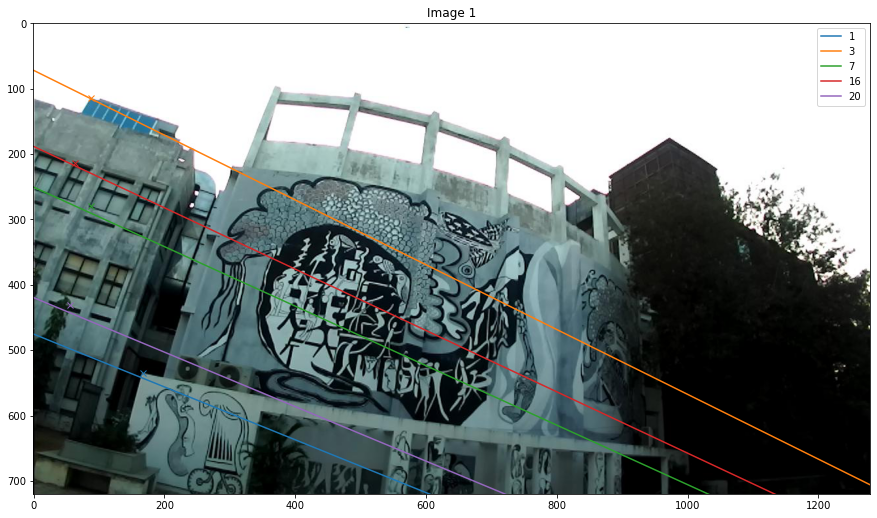

First image epipole at [4409.63060748 2256.63615316]


In [129]:
# Show the line in image 1
plt.figure(figsize=(15, 10))
plt.title("Image 1")
img1_plt = cv.cvtColor(img1.copy(), cv.COLOR_BGR2RGB)   # Copy
plt.imshow(img1_plt)
plt.autoscale(False)
x_min, x_max = 0, img1.shape[1] # Width of image
y_min, y_max = 0, img1.shape[0] # Height of image
for cn in img2_corr_point_ind:
    ci = cn - 1    # Index of correspondence
    # Get point in image 2 (homogeneous)
    x_im2 = im2_pts[:, ci]
    lep_ci_im1 = F @ x_im2    # Epipolar line for corresponding point
    nlep_im1 = lep_ci_im1 / lep_ci_im1[2]
    lny = lambda x: -(x*nlep_im1[0]+1)/nlep_im1[1]
    p = plt.plot([x_min, x_max], [lny(x_min), lny(x_max)], 
        label=f"{cn}")
    c = p[0].get_color()    # Color of the line
    px, py = im1_pts[:, ci][0:2] # Point in image 1 (actual)
    plt.plot(px, py, 'x', c=c, label="_nolegend_")
plt.legend()
plt.show()
# Print the epipole of first image
print(f"First image epipole at {epn_im1[0:2]}")

#### Step 3: Epipolar lines in the second image

For a point in the first image $\mathbf{x}'$, the epipolar line in the second image is given by $l'' = \mathbf{F}^\top \mathbf{x}'$. Note that we already have (true) correspondences, se we can verify them by plotting.


In [130]:
# Pick a set of points in image 1 (out of 20, start = 1)
img1_corr_point_ind = [1, 3, 7, 20]

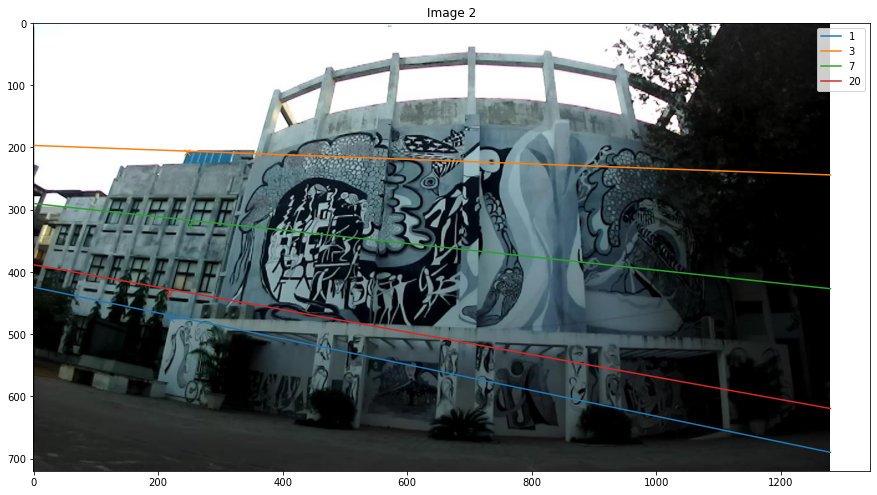

Second image epipole at [-1336.63751852   147.37035827]


In [131]:
# Show the line in image 2
plt.figure(figsize=(15, 10))
plt.title("Image 2")
img2_plt = cv.cvtColor(img2.copy(), cv.COLOR_BGR2RGB)   # Copy
plt.imshow(img2_plt)
x_min, x_max = 0, img2.shape[1] # Width of image
y_min, y_max = 0, img2.shape[0] # Height of image
for cn in img1_corr_point_ind:
    ci = cn - 1    # Index of correspondence
    # Get point in image 1
    x_im1 = im1_pts[:, ci]
    lep_ci_im2 = F.T @ x_im1    # Epipolar line for corresponding point
    nlep_im2 = lep_ci_im2 / lep_ci_im2[2]
    lny = lambda x: -(x*nlep_im2[0]+1)/nlep_im2[1]
    p = plt.plot([x_min, x_max], [lny(x_min), lny(x_max)], 
        label=f"{cn}")
    c = p[0].get_color()    # Color of the line
    px, py = im2_pts[:, ci][0:2] # 
    plt.plot(px, py, 'x', c=c, label="_nolegend_")
plt.legend()
plt.show()
# Print the epipole of second image
print(f"Second image epipole at {epn_im2[0:2]}")

Note that the true corresponding points are nearly on the epipolar lines (there's always going to be some error).

#### Step 4: Verify that lines intersect at epipoles

We can verify that the lines intersect at the epipoles by picking two epipolar lines, and seeing that they actually intersect at the estimated epipoles (for a particular image).

**Image 1**


In [163]:
# Any tow points (in image 2)
im2_corr_points = [20, 6]    # Pick from correspondences (start = 1)
im2_p1 = im2_pts[:, im2_corr_points[0]-1]
im2_p2 = im2_pts[:, im2_corr_points[1]-1]

In [164]:
# Find the epipolar lines
el_im1_im2p1 = F @ im2_p1
el1n = el_im1_im2p1 / el_im1_im2p1[2]   # Line 1 (normalized)
el_im1_im2p2 = F @ im2_p2
el2n = el_im1_im2p2 / el_im1_im2p2[2]   # Line 2 (normalized)
# Find intersection
l1, l2, l3, l4 = el1n[0], el1n[1], el2n[0], el2n[1]
x = (l4-l2)/(l3*l2-l4*l1)
y = -(1+l1*x)/l2
print(f"Lines intersect at (x, y): [{x}, {y}]")
print(f"Epipole actually at (x, y): [{epn_im1[0]}, {epn_im1[1]}]")
d = ((x-epn_im1[0])**2+(y-epn_im1[1])**2)**0.5
print(f"Distance is: {d}")
if d < 1e-6:    # Distance in pixel coordinates
    print("Lines appear to intersect at the correct epipole")
else:
    print("ERROR: Lines do not appear to intersect at epipole!")

Lines intersect at (x, y): [4409.630607479314, 2256.636153164786]
Epipole actually at (x, y): [4409.63060747803, 2256.6361531640828]
Distance is: 1.4640528636057244e-09
Lines appear to intersect at the correct epipole


**Image 2**


In [165]:
# Any tow points (in image 1)
im1_corr_points = [17, 10]    # Pick from correspondences (start = 1)
im1_p1 = im1_pts[:, im1_corr_points[0]-1]
im1_p2 = im1_pts[:, im1_corr_points[1]-1]

In [166]:
# Find the epipolar lines
el_im2_im1p1 = F.T @ im1_p1
el1n = el_im2_im1p1 / el_im2_im1p1[2]   # Line 1 (normalized)
el_im2_im1p2 = F.T @ im1_p2
el2n = el_im2_im1p2 / el_im2_im1p2[2]   # Line 2 (normalized)
# Find intersection
l1, l2, l3, l4 = el1n[0], el1n[1], el2n[0], el2n[1]
x = (l4-l2)/(l3*l2-l4*l1)
y = -(1+l1*x)/l2
print(f"Lines intersect at (x, y): [{x}, {y}]")
print(f"Epipole actually at (x, y): [{epn_im2[0]}, {epn_im2[1]}]")
d = ((x-epn_im2[0])**2+(y-epn_im2[1])**2)**0.5
print(f"Distance is: {d}")
if d < 1e-6:    # Distance in pixel coordinates
    print("Lines appear to intersect at the correct epipole")
else:
    print("ERROR: Lines do not appear to intersect at epipole!")

Lines intersect at (x, y): [-1336.6375185239908, 147.37035827250523]
Epipole actually at (x, y): [-1336.6375185241207, 147.37035827250054]
Distance is: 1.299150368931469e-10
Lines appear to intersect at the correct epipole


As seen through above, the epipoles actually are at the intersection of epipolar lines.

In [168]:
# For rough work! Leave blank

---


## 4.3 Drawing a bounding box around a car and localizing it in the camera frame

You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)